# 4. Model Training — Home Credit Default Risk

Bu notebook'ta preprocessing sonrası **model-ready** veri üzerinde tam modelleme pipeline'ı çalıştırılacaktır.

| Sıra | Adım | Açıklama |
|------|------|----------|
| 1 | **Baseline LightGBM** | Stratified K-Fold (5) + `scale_pos_weight` ile tuning'siz model |
| 2 | **Baseline XGBoost** | Aynı CV ve aynı imbalance ayarlarıyla karşılaştırma modeli |
| 3 | **Model Seçimi** | AUC / PR-AUC ortalamasına bakıp en iyi baseline'ı seçme |
| 4 | **Optuna Tuning (AUC)** | Seçilen model için 50 trial AUC-optimized arama |
| 5a | **Optuna Tuning (PR-AUC)** | İmbalanced data için PR-AUC-optimized 50 trial |
| 5b | **Study Karşılaştırma** | AUC vs PR-AUC study seçimi |
| 5c | **Leakage & Stability** | Feature leakage, dominance, fold stability kontrolü |
| 6 | **Threshold (Baseline)** | Ön threshold analizi (baseline OOF) |
| 7 | **Final Model + CV** | En iyi ayarlarla tekrar CV + OOF + test tahminleri |
| 8 | **Calibration** | Brier score, reliability diagram, calibration assessment |
| 9 | **Threshold Optimizasyonu** | Business cost-based threshold (final model OOF) |
| 10 | **SHAP Analizi** | Global + bireysel açıklanabilirlik |

**Girdi:**
- `data/train_processed.parquet` — 307,511 x 169 (0 NaN, 0 kategorik)
- `data/test_processed.parquet` — 48,744 x 168

**Çıktı:**
- `models/lgbm_best_fold.pkl` — En iyi tek fold modeli
- `models/lgbm_all_folds.pkl` — Tüm fold modelleri (ensemble)
- `models/best_params.json` — En iyi hiperparametreler
- `data/oof_predictions.parquet` — OOF tahminleri
- `data/test_predictions.parquet` — Test tahminleri

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import pickle
import json

import lightgbm as lgb
import xgboost as xgb
import optuna
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

RANDOM_STATE = 42
N_FOLDS = 5

os.makedirs('../notebooks/plots', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print('Setup complete.')

Setup complete.


---
## 1. Veri Yükleme ve Hazırlık

In [3]:
# Load processed data
df = pd.read_parquet('../data/train_processed.parquet')
test_df = pd.read_parquet('../data/test_processed.parquet')

print(f'Train: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'Test:  {test_df.shape[0]:,} rows x {test_df.shape[1]} columns')

# Split features and target
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

test_ids = test_df['SK_ID_CURR']
X_test = test_df.drop(columns=['SK_ID_CURR'])

# Class balance
print(f'\nTarget Distribution:')
print(y.value_counts())
print(f'\nDefault Rate: {y.mean():.4f} ({y.mean()*100:.2f}%)')
print(f'Imbalance Ratio: 1:{(1-y.mean())/y.mean():.1f}')
print(f'\nFeatures: {X.shape[1]}')
print(f'Feature dtypes:\n{X.dtypes.value_counts()}')

Train: 307,511 rows x 169 columns
Test:  48,744 rows x 168 columns

Target Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default Rate: 0.0807 (8.07%)
Imbalance Ratio: 1:11.4

Features: 167
Feature dtypes:
float32    75
int8       35
float64    33
int64      22
int16       2
Name: count, dtype: int64


In [4]:
# CV strategy
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# scale_pos_weight for imbalanced classes
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f'scale_pos_weight: {scale_pos_weight:.2f}')
print(f'CV Strategy: Stratified {N_FOLDS}-Fold (shuffle=True, seed={RANDOM_STATE})')

scale_pos_weight: 11.39
CV Strategy: Stratified 5-Fold (shuffle=True, seed=42)


---
## 2. Baseline LightGBM

İlk model: Varsayılan parametrelerle LightGBM.

- `scale_pos_weight` ile sınıf dengesizliği yönetimi
- `early_stopping(100)` ile overfitting kontrolü
- 5-Fold Stratified CV ile güvenilir performans ölçümü

> **Neden LightGBM?** Tabular, numeric-only ve dengesiz veride en stabil başlangıç noktası.
> NaN native desteği, hızlı eğitim, düşük bellek kullanımı.

In [5]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 2000,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}

print('=' * 60)
print('BASELINE LightGBM  —  Stratified 5-Fold CV')
print('=' * 60)

lgb_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
lgb_models = []
lgb_oof_preds = np.zeros(len(X))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    lgb_oof_preds[val_idx] = y_pred

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    lgb_results['auc'].append(auc)
    lgb_results['pr_auc'].append(pr_auc)
    lgb_results['best_iter'].append(model.best_iteration_)
    lgb_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={model.best_iteration_}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(lgb_results["auc"]):.5f} +/- {np.std(lgb_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(lgb_results["pr_auc"]):.5f} +/- {np.std(lgb_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(lgb_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

lgb_oof_auc = roc_auc_score(y, lgb_oof_preds)
print(f'\n  OOF AUC:     {lgb_oof_auc:.5f}')

BASELINE LightGBM  —  Stratified 5-Fold CV
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's auc: 0.781784
  Fold 1: AUC=0.78178 | PR-AUC=0.27475 | best_iter=361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	valid_0's auc: 0.789723
  Fold 2: AUC=0.78972 | PR-AUC=0.28526 | best_iter=370
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's auc: 0.782185
  Fold 3: AUC=0.78219 | PR-AUC=0.26733 | best_iter=364
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	valid_0's auc: 0.786553
  Fold 4: AUC=0.78655 | PR-AUC=0.27776 | best_iter=385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	valid_0's auc: 0.780863
  Fold 5: AUC=0.78086 | PR-AUC=0.27131 | best_iter=314

——————————————————————————————————————————————

---
## 3. Baseline XGBoost

Aynı CV yapısı ile XGBoost karşılaştırması.

- `scale_pos_weight` aynı değer
- `tree_method='hist'` ile hızlı eğitim
- `early_stopping_rounds=100`

> **Neden XGBoost da?** LightGBM'e alternatif güçlü bir ağaç modeliyle benchmark oluşturmak
> ve hangi algoritmanın sinyali daha iyi yakaladığını görmek için.

In [8]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 2000,
    'verbosity': 0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
}

print('=' * 60)
print('BASELINE XGBoost  —  Stratified 5-Fold CV')
print('=' * 60)

xgb_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
xgb_models = []
xgb_oof_preds = np.zeros(len(X))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    xgb_oof_preds[val_idx] = y_pred

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    xgb_results['auc'].append(auc)
    xgb_results['pr_auc'].append(pr_auc)
    best_iter = getattr(model, 'best_iteration', getattr(model, 'best_iteration_', -1))
    xgb_results['best_iter'].append(best_iter)
    xgb_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={best_iter}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(xgb_results["auc"]):.5f} +/- {np.std(xgb_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(xgb_results["pr_auc"]):.5f} +/- {np.std(xgb_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(xgb_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

xgb_oof_auc = roc_auc_score(y, xgb_oof_preds)
print(f'\n  OOF AUC:     {xgb_oof_auc:.5f}')

BASELINE XGBoost  —  Stratified 5-Fold CV
  Fold 1: AUC=0.77904 | PR-AUC=0.27154 | best_iter=303
  Fold 2: AUC=0.78700 | PR-AUC=0.28016 | best_iter=342
  Fold 3: AUC=0.77996 | PR-AUC=0.26686 | best_iter=301
  Fold 4: AUC=0.78370 | PR-AUC=0.27795 | best_iter=302
  Fold 5: AUC=0.77748 | PR-AUC=0.26695 | best_iter=332

————————————————————————————————————————————————————————————
  Mean AUC:    0.78144 +/- 0.00345
  Mean PR-AUC: 0.27269 +/- 0.00551
  Mean Iters:  316
  Elapsed:     77.1s (1.3 min)

  OOF AUC:     0.78142


---
## 4. Model Seçimi — Baseline Karşılaştırması

AUC-ROC ve PR-AUC ortalamalarına bakarak hangi modelle tuning'e geçeceğimize karar veriyoruz.

> **Kural:** Kötü modeli tune etmek zaman kaybıdır — önce doğru atı seç.

BASELINE COMPARISON
   Model  AUC Mean  AUC Std  PR-AUC Mean  PR-AUC Std  OOF AUC  Avg Iters
LightGBM  0.784222 0.003378     0.275283    0.006083 0.784218      358.8
 XGBoost  0.781436 0.003453     0.272692    0.005507 0.781421      316.0


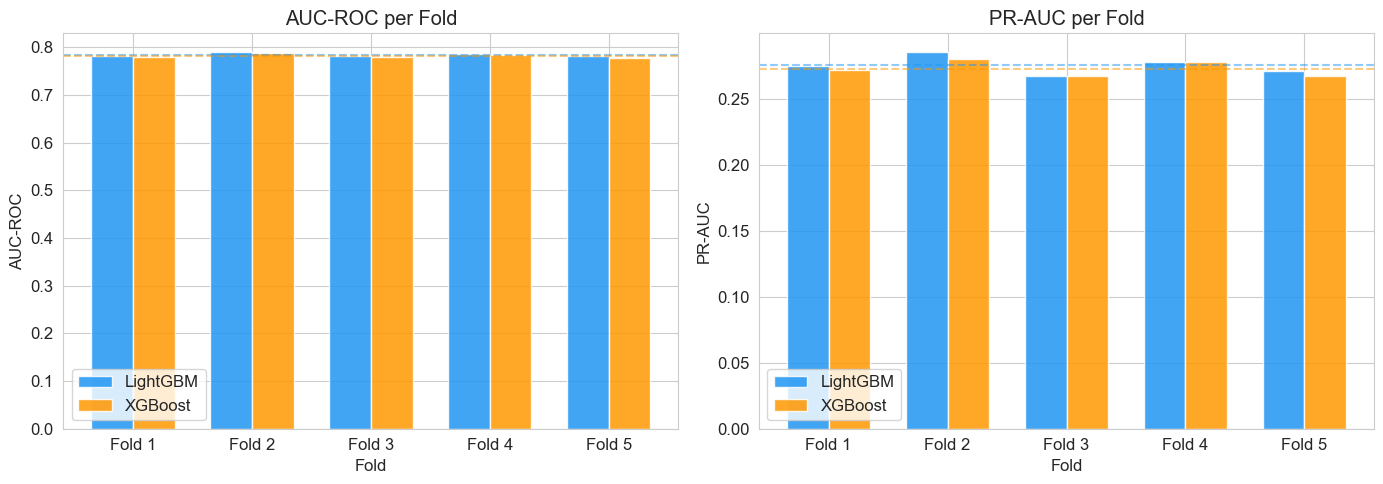


SECILEN MODEL: LightGBM (daha yuksek AUC Mean)


In [9]:
# Comparison table
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'AUC Mean': [np.mean(lgb_results['auc']), np.mean(xgb_results['auc'])],
    'AUC Std': [np.std(lgb_results['auc']), np.std(xgb_results['auc'])],
    'PR-AUC Mean': [np.mean(lgb_results['pr_auc']), np.mean(xgb_results['pr_auc'])],
    'PR-AUC Std': [np.std(lgb_results['pr_auc']), np.std(xgb_results['pr_auc'])],
    'OOF AUC': [lgb_oof_auc, xgb_oof_auc],
    'Avg Iters': [np.mean(lgb_results['best_iter']), np.mean(xgb_results['best_iter'])],
})

print('BASELINE COMPARISON')
print('=' * 80)
print(comparison.to_string(index=False))

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(N_FOLDS)
width = 0.35

# AUC per fold
axes[0].bar(x - width/2, lgb_results['auc'], width, label='LightGBM', color='#2196F3', alpha=0.85)
axes[0].bar(x + width/2, xgb_results['auc'], width, label='XGBoost', color='#FF9800', alpha=0.85)
axes[0].axhline(y=np.mean(lgb_results['auc']), color='#2196F3', linestyle='--', alpha=0.5)
axes[0].axhline(y=np.mean(xgb_results['auc']), color='#FF9800', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('AUC-ROC')
axes[0].set_title('AUC-ROC per Fold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)])
axes[0].legend()

# PR-AUC per fold
axes[1].bar(x - width/2, lgb_results['pr_auc'], width, label='LightGBM', color='#2196F3', alpha=0.85)
axes[1].bar(x + width/2, xgb_results['pr_auc'], width, label='XGBoost', color='#FF9800', alpha=0.85)
axes[1].axhline(y=np.mean(lgb_results['pr_auc']), color='#2196F3', linestyle='--', alpha=0.5)
axes[1].axhline(y=np.mean(xgb_results['pr_auc']), color='#FF9800', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('PR-AUC')
axes[1].set_title('PR-AUC per Fold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)])
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebooks/plots/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Model selection
best_baseline = 'LightGBM' if np.mean(lgb_results['auc']) >= np.mean(xgb_results['auc']) else 'XGBoost'
print(f'\nSECILEN MODEL: {best_baseline} (daha yuksek AUC Mean)')

---
## 5. Optuna ile Hyperparameter Tuning

Seçilen model (LightGBM) için **50 trial** hiperparametre optimizasyonu.

Aranacak parametreler:
- `learning_rate`: [0.01, 0.1] (log scale)
- `num_leaves`: [20, 150]
- `max_depth`: [3, 12]
- `min_child_samples`: [10, 100]
- `reg_alpha` / `reg_lambda`: [1e-8, 10] (log scale)
- `colsample_bytree` / `subsample`: [0.5, 1.0]
- `min_split_gain`: [0.0, 1.0]

> **Neden Optuna?** Bayesian optimizasyon ile grid/random search'ten cok daha verimli.
> TPE sampler ile 50 trial'da iyi bir noktaya ulasilir.

In [10]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'n_estimators': 2000,
        'verbose': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    }

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(auc_scores)


print('=' * 60)
print('OPTUNA HYPERPARAMETER TUNING  —  50 Trials x 5-Fold CV')
print('=' * 60)

start = time.time()
study = optuna.create_study(direction='maximize', study_name='lgbm_tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)
elapsed = time.time() - start

print(f'\nBest Trial: #{study.best_trial.number}')
print(f'Best AUC:   {study.best_value:.5f}')
print(f'Elapsed:    {elapsed:.1f}s ({elapsed/60:.1f} min)')
print(f'\nBest Parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

OPTUNA HYPERPARAMETER TUNING  —  50 Trials x 5-Fold CV


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[848]	valid_0's auc: 0.782393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	valid_0's auc: 0.790089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[725]	valid_0's auc: 0.784114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[838]	valid_0's auc: 0.788544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	valid_0's auc: 0.783283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[493]	valid_0's auc: 0.782257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's auc: 0.788899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid_0's auc: 0

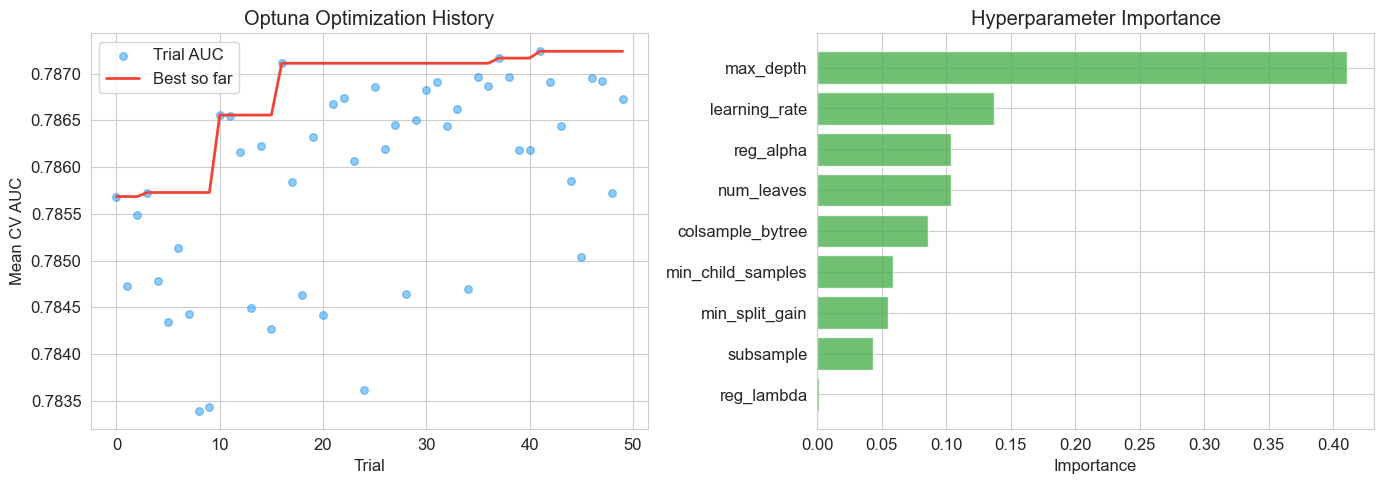


Baseline LightGBM AUC: 0.78422
Optuna Best AUC:       0.78724
Improvement:           30.2 bps


In [11]:
# Optuna visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials if t.value is not None]
trial_nums_valid = [t.number for t in trials if t.value is not None]
best_so_far = [max(trial_values[:i+1]) for i in range(len(trial_values))]

axes[0].scatter(trial_nums_valid, trial_values, alpha=0.5, color='#2196F3', s=30, label='Trial AUC')
axes[0].plot(trial_nums_valid, best_so_far, color='#F44336', linewidth=2, label='Best so far')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Mean CV AUC')
axes[0].set_title('Optuna Optimization History')
axes[0].legend()

# Parameter importance
try:
    param_importance = optuna.importance.get_param_importances(study)
    params_sorted = dict(sorted(param_importance.items(), key=lambda x: x[1], reverse=True))
    axes[1].barh(
        list(params_sorted.keys())[::-1],
        list(params_sorted.values())[::-1],
        color='#4CAF50', alpha=0.8
    )
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Hyperparameter Importance')
except Exception as e:
    axes[1].text(0.5, 0.5, f'Could not compute\nimportance: {e}',
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('../notebooks/plots/optuna_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

# Baseline vs Tuned comparison
print(f'\nBaseline LightGBM AUC: {np.mean(lgb_results["auc"]):.5f}')
print(f'Optuna Best AUC:       {study.best_value:.5f}')
print(f'Improvement:           {(study.best_value - np.mean(lgb_results["auc"]))*10000:.1f} bps')

---
## 5b. Optuna — PR-AUC Optimizasyonu

AUC-ROC genel ayırım gücünü ölçer, ama **imbalanced** problemlerde (%8 default)
**PR-AUC** (Average Precision) pozitif sınıfın yakalanma kalitesini daha iyi yansıtır.

İki study'yi karşılaştırıp **her iki metrikte de en iyi** parametreleri seçeceğiz.

> **Neden ikisi de?** AUC-optimized model genel sıralamada iyi olur,
> PR-AUC-optimized model default'ları yakalamada daha agresif olur.
> Hangisi daha iyi çalışırsa o seçilir.

In [12]:
def objective_prauc(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'n_estimators': 2000,
        'verbose': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    }

    prauc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        prauc_scores.append(average_precision_score(y_val, y_pred))

    return np.mean(prauc_scores)


print('=' * 60)
print('OPTUNA PR-AUC TUNING  —  50 Trials x 5-Fold CV')
print('=' * 60)

start = time.time()
study_prauc = optuna.create_study(direction='maximize', study_name='lgbm_prauc_tuning')
study_prauc.optimize(objective_prauc, n_trials=50, show_progress_bar=True)
elapsed = time.time() - start

print(f'\nBest Trial: #{study_prauc.best_trial.number}')
print(f'Best PR-AUC: {study_prauc.best_value:.5f}')
print(f'Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')
print(f'\nBest Parameters:')
for key, value in study_prauc.best_params.items():
    print(f'  {key}: {value}')

OPTUNA PR-AUC TUNING  —  50 Trials x 5-Fold CV


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1360]	valid_0's auc: 0.783708
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1119]	valid_0's auc: 0.791221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1519]	valid_0's auc: 0.784738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1337]	valid_0's auc: 0.789018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1513]	valid_0's auc: 0.784078
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's auc: 0.78297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.789125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's au

In [13]:
# ---- Compare AUC-optimized vs PR-AUC-optimized ----
# Quick CV evaluation of PR-AUC study params with BOTH metrics
prauc_eval_params = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 2000, 'verbose': -1,
    'random_state': RANDOM_STATE, 'n_jobs': -1,
}
prauc_eval_params.update(study_prauc.best_params)

prauc_study_auc = []
prauc_study_prauc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
    m = lgb.LGBMClassifier(**prauc_eval_params)
    m.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)],
          callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    yp = m.predict_proba(X_vl)[:, 1]
    prauc_study_auc.append(roc_auc_score(y_vl, yp))
    prauc_study_prauc.append(average_precision_score(y_vl, yp))

# Comparison table
print('=' * 70)
print('STUDY COMPARISON — AUC-optimized vs PR-AUC-optimized')
print('=' * 70)

comp_df = pd.DataFrame({
    'Study': ['AUC-optimized', 'PR-AUC-optimized'],
    'AUC Mean': [np.mean(lgb_results['auc']), np.mean(prauc_study_auc)],
    'AUC (Optuna best)': [study.best_value, np.mean(prauc_study_auc)],
    'PR-AUC Mean': [np.mean(lgb_results['pr_auc']), np.mean(prauc_study_prauc)],
})
print(comp_df.to_string(index=False))

# Select best study
auc_winner = 'AUC' if study.best_value >= np.mean(prauc_study_auc) else 'PR-AUC'
prauc_winner = 'AUC' if np.mean(lgb_results['pr_auc']) >= np.mean(prauc_study_prauc) else 'PR-AUC'

# Use PR-AUC-optimized if it wins PR-AUC AND doesn't lose much AUC
auc_diff = study.best_value - np.mean(prauc_study_auc)
prauc_diff = np.mean(prauc_study_prauc) - np.mean(lgb_results['pr_auc'])

if prauc_diff > 0 and auc_diff < 0.005:
    best_study = study_prauc
    best_study_name = 'PR-AUC-optimized'
    print(f'\nSECILEN: PR-AUC-optimized (PR-AUC +{prauc_diff*10000:.1f} bps, AUC fark {-auc_diff*10000:.1f} bps)')
else:
    best_study = study
    best_study_name = 'AUC-optimized'
    print(f'\nSECILEN: AUC-optimized (AUC daha yuksek veya PR-AUC farki yetersiz)')

print(f'\nFinal model {best_study_name} parametreleri ile egitilecek.')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1300]	valid_0's auc: 0.784424
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1148]	valid_0's auc: 0.791695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1260]	valid_0's auc: 0.785342
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1262]	valid_0's auc: 0.789263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1226]	valid_0's auc: 0.784638
STUDY COMPARISON — AUC-optimized vs PR-AUC-optimized
           Study  AUC Mean  AUC (Optuna best)  PR-AUC Mean
   AUC-optimized  0.784222           0.787239     0.275283
PR-AUC-optimized  0.787072           0.787072     0.279690

SECILEN: PR-AUC-optimized (PR-AUC +44.1 bps, AUC fark -1.7 bps)

Final model PR-AUC-optimized parametreleri ile egitilecek.


---
## 5c. Leakage & Stability Kontrolü

Final modele geçmeden önce **3 kritik kontrol**:

| Kontrol | Ne Bakıyoruz | Risk |
|---------|-------------|------|
| **A) Feature Leakage** | TARGET ile abs(corr) > 0.95 | Veri sızıntısı → gerçek dışı yüksek AUC |
| **B) Feature Dominance** | Tek feature >50% importance | Leakage veya overly engineered feature |
| **C) Fold Stability** | Fold arası metrik ve importance varyansı | Overfit, instabil model |

> Eğer leakage varsa → o feature drop edilip tekrar CV koşulmalı.
> AUC dramatik düşüyorsa → feature gerçekten leaky demektir.

In [17]:
# ============================================================
# A) FEATURE LEAKAGE KONTROLÜ
# ============================================================

print('=' * 70)
print('FEATURE LEAKAGE KONTROLÜ')
print('=' * 70)

# A1) Feature-Target Correlation
corr_with_target = X.corrwith(y).abs().sort_values(ascending=False)
high_corr = corr_with_target[corr_with_target > 0.95]

print('\n--- A1) Feature-Target Korelasyon (abs > 0.95) ---')
if len(high_corr) > 0:
    print(f'  ⚠ {len(high_corr)} feature TARGET ile abs(corr) > 0.95:')
    for feat, corr_val in high_corr.items():
        print(f'     {feat}: {corr_val:.4f}')
    print('     → Bu feature\'lar leakage riski taşıyor!')
else:
    print('  ✓ TARGET ile abs(corr) > 0.95 olan feature yok.')

print(f'\n  Top 10 korelasyon (abs):')
for feat, corr_val in corr_with_target.head(10).items():
    print(f'     {feat}: {corr_val:.4f}')

# A2) Feature Importance Dominance
print('\n--- A2) Feature Importance Dominance (Baseline) ---')
importance_baseline = pd.DataFrame({
    'feature': X.columns,
    'importance': np.mean([m.feature_importances_ for m in lgb_models], axis=0)
})
importance_baseline = importance_baseline.sort_values('importance', ascending=False).reset_index(drop=True)

total_imp = importance_baseline['importance'].sum()
top1_pct = importance_baseline.iloc[0]['importance'] / total_imp * 100
top5_pct = importance_baseline.head(5)['importance'].sum() / total_imp * 100
top10_pct = importance_baseline.head(10)['importance'].sum() / total_imp * 100

print(f'  Top-1  feature: {importance_baseline.iloc[0]["feature"]} → {top1_pct:.1f}% total importance')
print(f'  Top-5  features → {top5_pct:.1f}% total importance')
print(f'  Top-10 features → {top10_pct:.1f}% total importance')

if top1_pct > 50:
    print(f'\n  ⚠ Top-1 feature %50\'den fazla dominance → Leakage riski!')
elif top1_pct > 30:
    print(f'\n  ⚠ Top-1 feature yüksek dominance → Dikkatli incelenmeli.')
else:
    print(f'\n  ✓ Feature importance sağlıklı dağılmış.')

# A3) Post-default feature kontrol
print('\n--- A3) Post-Default Feature Kontrolü ---')
suspect_kw = ['SK_DPD', 'STATUS_', 'DAYS_LAST_DUE', 'AMT_PAYMENT', 'MONTHS_BALANCE']
suspect_features = [f for f in X.columns
                    if any(kw.upper() in f.upper() for kw in suspect_kw)]

if suspect_features:
    print(f'  {len(suspect_features)} potansiyel post-default feature bulundu:')
    for f in suspect_features[:20]:
        cv = corr_with_target.get(f, 0)
        rank_row = importance_baseline[importance_baseline['feature'] == f]
        rank = int(rank_row.index[0]) + 1 if len(rank_row) > 0 else 'N/A'
        print(f'     {f}: corr={cv:.4f}, importance_rank=#{rank}')
    if len(suspect_features) > 20:
        print(f'     ... ve {len(suspect_features) - 20} daha')
    print('\n  Not: Yüksek corr + düşük rank → muhtemelen zararsız.')
    print('  Yüksek corr + yüksek rank → leakage riski → drop & re-CV önerilir.')
else:
    print('  Bilinen post-default keyword bulunamadı.')

print(f'\n{"="*70}')
print('SONUÇ: Yukarıdaki tabloları incele.')
print('Eğer high-corr veya dominant feature varsa, o feature drop edilip')
print('tekrar CV ile AUC kaybı ölçülmeli.')
print(f'{"="*70}')

FEATURE LEAKAGE KONTROLÜ

--- A1) Feature-Target Korelasyon (abs > 0.95) ---
  ✓ TARGET ile abs(corr) > 0.95 olan feature yok.

  Top 10 korelasyon (abs):
     EXT_SOURCE_2: 0.1600
     EXT_SOURCE_3: 0.1556
     EXT_SOURCE_1: 0.0979
     BUREAU_DAYS_CREDIT_MEAN: 0.0824
     DAYS_BIRTH: 0.0782
     INST_LATE_RATIO: 0.0709
     BUREAU_DEBT_CREDIT_RATIO: 0.0677
     PREV_REFUSED_COUNT: 0.0676
     BUREAU_DAYS_CREDIT_MIN: 0.0673
     INST_UNDERPAID_RATIO: 0.0646

--- A2) Feature Importance Dominance (Baseline) ---
  Top-1  feature: CREDIT_TERM → 4.6% total importance
  Top-5  features → 17.0% total importance
  Top-10 features → 27.8% total importance

  ✓ Feature importance sağlıklı dağılmış.

--- A3) Post-Default Feature Kontrolü ---
  9 potansiyel post-default feature bulundu:
     INST_AMT_PAYMENT_MEAN: corr=0.0265, importance_rank=#15
     INST_AMT_PAYMENT_SUM: corr=0.0213, importance_rank=#8
     POS_SK_DPD_MEAN: corr=0.0077, importance_rank=#93
     POS_SK_DPD_DEF_MAX: corr=0.0410, 

FOLD STABILITY ANALİZİ

--- LightGBM Baseline Fold Detayları ---
 Fold      AUC   PR-AUC  Best_Iter
    1 0.781784 0.274752        361
    2 0.789723 0.285263        370
    3 0.782185 0.267334        364
    4 0.786553 0.277757        385
    5 0.780863 0.271309        314

  AUC   range: 0.00886 (std: 0.00338)
  PR-AUC range: 0.01793 (std: 0.00608)
  ✓ AUC dalgalanması kabul edilebilir seviyede.

--- Per-Fold Feature Importance Varyansı ---

Top 15 feature — importance varyansı:
                  feature  mean_imp  std_imp   cv
              CREDIT_TERM    497.80    39.73 0.08
             EXT_SOURCE_2    355.80    15.38 0.04
             EXT_SOURCE_1    333.00    18.58 0.06
             EXT_SOURCE_3    328.60    31.32 0.10
               DAYS_BIRTH    313.80    24.81 0.08
      POS_REMAINING_RATIO    241.20    12.67 0.05
            DAYS_EMPLOYED    237.60    12.40 0.05
     INST_AMT_PAYMENT_SUM    237.40     8.80 0.04
              AMT_ANNUITY    226.00    26.18 0.12
        GOODS_

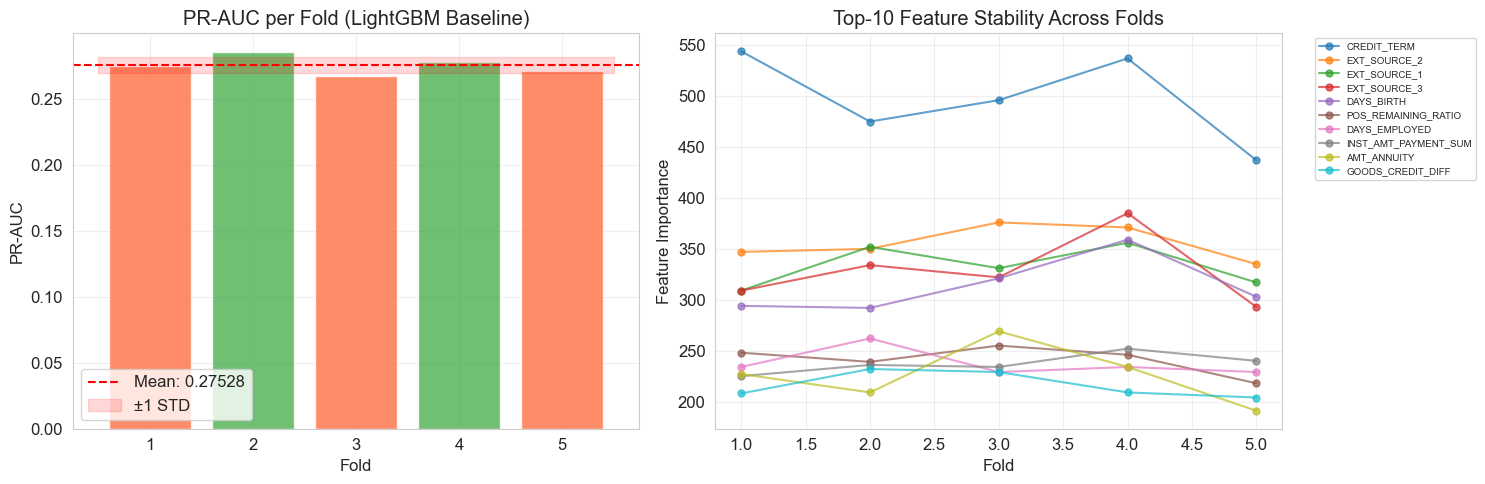


Fold stability grafikleri kaydedildi: plots/fold_stability.png


In [18]:
# ============================================================
# B) FOLD STABILITY ANALİZİ
# ============================================================

print('=' * 70)
print('FOLD STABILITY ANALİZİ')
print('=' * 70)

# Per-fold metrics table
print('\n--- LightGBM Baseline Fold Detayları ---')
fold_df = pd.DataFrame({
    'Fold': range(1, N_FOLDS + 1),
    'AUC': lgb_results['auc'],
    'PR-AUC': lgb_results['pr_auc'],
    'Best_Iter': lgb_results['best_iter']
})
print(fold_df.to_string(index=False))

auc_range = max(lgb_results['auc']) - min(lgb_results['auc'])
prauc_range = max(lgb_results['pr_auc']) - min(lgb_results['pr_auc'])

print(f'\n  AUC   range: {auc_range:.5f} (std: {np.std(lgb_results["auc"]):.5f})')
print(f'  PR-AUC range: {prauc_range:.5f} (std: {np.std(lgb_results["pr_auc"]):.5f})')

if auc_range > 0.02:
    print('  ⚠ AUC dalgalanması yüksek → Model instabil olabilir.')
elif auc_range > 0.01:
    print('  ⚠ AUC dalgalanması moderate → İzlenmeli.')
else:
    print('  ✓ AUC dalgalanması kabul edilebilir seviyede.')

# Per-fold feature importance variance
print('\n--- Per-Fold Feature Importance Varyansı ---')
fold_importances = np.array([m.feature_importances_ for m in lgb_models])
importance_std = fold_importances.std(axis=0)
importance_mean = fold_importances.mean(axis=0)
importance_cv = np.where(importance_mean > 0, importance_std / importance_mean, 0)

stability_df = pd.DataFrame({
    'feature': X.columns,
    'mean_imp': importance_mean,
    'std_imp': importance_std,
    'cv': importance_cv
})
stability_df = stability_df.sort_values('mean_imp', ascending=False).reset_index(drop=True)

print('\nTop 15 feature — importance varyansı:')
print(stability_df.head(15).to_string(index=False, float_format='%.2f'))

high_cv_top = stability_df.head(20)[stability_df.head(20)['cv'] > 0.5]
if len(high_cv_top) > 0:
    print(f'\n  ⚠ Top-20 feature arasında {len(high_cv_top)} tanesi yüksek varyans (CV > 0.5)')
else:
    print(f'\n  ✓ Top-20 feature\'da instabilite yok (CV < 0.5).')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PR-AUC per fold
colors = ['#FF7043' if v < np.mean(lgb_results['pr_auc']) else '#4CAF50'
          for v in lgb_results['pr_auc']]
axes[0].bar(range(1, N_FOLDS + 1), lgb_results['pr_auc'], color=colors, alpha=0.8)
axes[0].axhline(y=np.mean(lgb_results['pr_auc']), color='red', linestyle='--',
                label=f'Mean: {np.mean(lgb_results["pr_auc"]):.5f}')
axes[0].fill_between(
    [0.5, N_FOLDS + 0.5],
    np.mean(lgb_results['pr_auc']) - np.std(lgb_results['pr_auc']),
    np.mean(lgb_results['pr_auc']) + np.std(lgb_results['pr_auc']),
    alpha=0.15, color='red', label='±1 STD'
)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('PR-AUC')
axes[0].set_title('PR-AUC per Fold (LightGBM Baseline)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top-10 feature importance across folds
top10_feats = stability_df.head(10)['feature'].values
col_indices = [list(X.columns).index(f) for f in top10_feats]
top10_fold_imp = fold_importances[:, col_indices]

for i, feat in enumerate(top10_feats):
    axes[1].plot(range(1, N_FOLDS + 1), top10_fold_imp[:, i], 'o-',
                 label=feat[:25], alpha=0.7, markersize=5)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Feature Importance')
axes[1].set_title('Top-10 Feature Stability Across Folds')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/fold_stability.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n{"="*70}')
print('Fold stability grafikleri kaydedildi: plots/fold_stability.png')
print(f'{"="*70}')

---
## 6. Imbalance Kontrolu

Baseline'da `scale_pos_weight` kullandik. Recall yeterli mi kontrol ediyoruz.

> **Not:** SMOTE tree-based modellerde genellikle gereksizdir — `scale_pos_weight`
> ayni etkiyi gradient duzeyinde saglar. Sadece ihtiyac halinde denenecek.

In [14]:
# Recall check with different thresholds using LightGBM baseline OOF predictions
print('Threshold Analysis (LightGBM Baseline OOF Predictions)')
print('=' * 70)

thresholds = [0.50, 0.30, 0.20, 0.15, 0.10]
threshold_results = []

for thr in thresholds:
    y_pred_binary = (lgb_oof_preds >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    threshold_results.append({
        'Threshold': thr,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    })

thr_df = pd.DataFrame(threshold_results)
print(thr_df.to_string(index=False, float_format='%.4f'))

print(f'\nYorum: Recall degerleri inceleniyor...')
print(f'scale_pos_weight={scale_pos_weight:.1f} ile calisiyoruz.')
print(f'Eger recall cok dusukse (threshold=0.5 ile <0.30), alternatif denenebilir.')
print(f'Tree-based modellerde scale_pos_weight genellikle yeterlidir.')

Threshold Analysis (LightGBM Baseline OOF Predictions)
 Threshold  Precision  Recall     F1    TP     FP   FN     TN
    0.5000     0.1880  0.6854 0.2951 17014  73476 7811 209210
    0.3000     0.1287  0.8812 0.2246 21877 148134 2948 134552
    0.2000     0.1062  0.9478 0.1909 23530 198108 1295  84578
    0.1500     0.0964  0.9729 0.1754 24152 226414  673  56272
    0.1000     0.0879  0.9913 0.1616 24608 255212  217  27474

Yorum: Recall degerleri inceleniyor...
scale_pos_weight=11.4 ile calisiyoruz.
Eger recall cok dusukse (threshold=0.5 ile <0.30), alternatif denenebilir.
Tree-based modellerde scale_pos_weight genellikle yeterlidir.


---
## 7. Final Model — Tuned LightGBM + Full CV

Optuna'nin buldugu en iyi parametrelerle tam 5-Fold CV calistiriyoruz.

Bu sefer ayrica:
- **OOF (Out-of-Fold) tahminleri** kaydedilecek (her satir bir kez val olarak gorulur)
- **Test tahminleri** 5 fold ortalamasiyla hesaplanacak (ensemble)
- **ROC ve PR-AUC egileri** cizilecek

In [19]:
# Build final params from best study (AUC or PR-AUC optimized)
final_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 2000,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}
final_params.update(best_study.best_params)

# Metric alignment: early stopping metric = optimization objective
if best_study_name == 'PR-AUC-optimized':
    final_params['metric'] = 'None'  # disable default AUC metric
    def prauc_eval(y_true, y_pred):
        """Custom PR-AUC eval for early stopping alignment."""
        return 'pr_auc', average_precision_score(y_true, y_pred), True
    custom_eval_metric = prauc_eval
    print(f'Using: {best_study_name} parameters')
    print(f'  Early stopping metric: PR-AUC (aligned with optimization)')
else:
    custom_eval_metric = None
    print(f'Using: {best_study_name} parameters')
    print(f'  Early stopping metric: AUC (default)')

print('=' * 60)
print('FINAL MODEL  —  Tuned LightGBM  —  Stratified 5-Fold CV')
print('=' * 60)
print(f'\nParameters:')
for k, v in final_params.items():
    if k not in ['verbose', 'random_state', 'n_jobs']:
        val_str = f'{v:.6f}' if isinstance(v, float) else str(v)
        print(f'  {k}: {val_str}')

final_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
final_models = []
final_oof_preds = np.zeros(len(X))
final_test_preds = np.zeros(len(X_test))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=custom_eval_metric,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    final_oof_preds[val_idx] = y_pred

    # Test prediction — average across folds (ensemble)
    final_test_preds += model.predict_proba(X_test)[:, 1] / N_FOLDS

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    final_results['auc'].append(auc)
    final_results['pr_auc'].append(pr_auc)
    final_results['best_iter'].append(model.best_iteration_)
    final_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={model.best_iteration_}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(final_results["auc"]):.5f} +/- {np.std(final_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(final_results["pr_auc"]):.5f} +/- {np.std(final_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(final_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

final_oof_auc = roc_auc_score(y, final_oof_preds)
final_oof_prauc = average_precision_score(y, final_oof_preds)
print(f'\n  OOF AUC:     {final_oof_auc:.5f}')
print(f'  OOF PR-AUC:  {final_oof_prauc:.5f}')

# Improvement summary
baseline_auc = np.mean(lgb_results['auc'])
tuned_auc = np.mean(final_results['auc'])
print(f'\n  Baseline AUC: {baseline_auc:.5f}')
print(f'  Tuned AUC:    {tuned_auc:.5f}')
print(f'  Improvement:  {(tuned_auc - baseline_auc)*10000:+.1f} bps')

# ---- Full-Data Single Model ----
mean_best_iter = int(np.mean(final_results['best_iter']))
full_n_estimators = int(mean_best_iter * 1.1)

full_params = final_params.copy()
full_params['n_estimators'] = full_n_estimators
full_params['metric'] = 'auc'  # no eval_set needed, safe default

print(f'\n{"="*60}')
print(f'FULL-DATA SINGLE MODEL')
print(f'{"="*60}')
print(f'  n_estimators: {full_n_estimators} (mean_best_iter={mean_best_iter} x 1.1)')

start_full = time.time()
full_model = lgb.LGBMClassifier(**full_params)
full_model.fit(X, y)
full_elapsed = time.time() - start_full

full_test_preds = full_model.predict_proba(X_test)[:, 1]

print(f'  Trained in {full_elapsed:.1f}s')
print(f'  Test predictions: {len(X_test):,} samples')
print(f'  Ensemble vs Single correlation: {np.corrcoef(final_test_preds, full_test_preds)[0,1]:.6f}')

Using: PR-AUC-optimized parameters
  Early stopping metric: PR-AUC (aligned with optimization)
FINAL MODEL  —  Tuned LightGBM  —  Stratified 5-Fold CV

Parameters:
  objective: binary
  metric: None
  boosting_type: gbdt
  scale_pos_weight: 11.387150
  n_estimators: 2000
  learning_rate: 0.015435
  num_leaves: 45
  max_depth: 8
  min_child_samples: 97
  reg_alpha: 0.031602
  reg_lambda: 0.004388
  colsample_bytree: 0.593150
  subsample: 0.581157
  min_split_gain: 0.796035
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1144]	valid_0's pr_auc: 0.278233
  Fold 1: AUC=0.78429 | PR-AUC=0.27823 | best_iter=1144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's pr_auc: 0.289795
  Fold 2: AUC=0.79137 | PR-AUC=0.28979 | best_iter=900
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[978]	valid_0's pr_auc: 0.273732
  Fold 3: AUC=0.78511

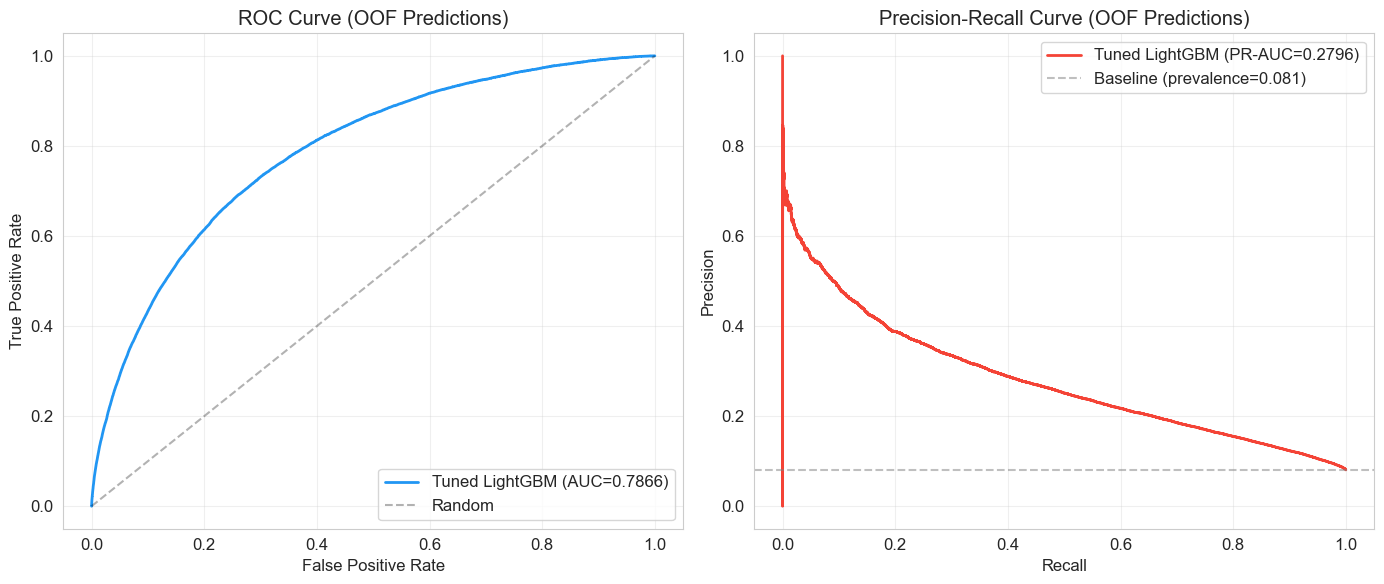

In [20]:
# ROC and Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y, final_oof_preds)
axes[0].plot(fpr, tpr, color='#2196F3', linewidth=2,
             label=f'Tuned LightGBM (AUC={final_oof_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (OOF Predictions)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# PR Curve
precision_arr, recall_arr, _ = precision_recall_curve(y, final_oof_preds)
axes[1].plot(recall_arr, precision_arr, color='#F44336', linewidth=2,
             label=f'Tuned LightGBM (PR-AUC={final_oof_prauc:.4f})')
axes[1].axhline(y=y.mean(), color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline (prevalence={y.mean():.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (OOF Predictions)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

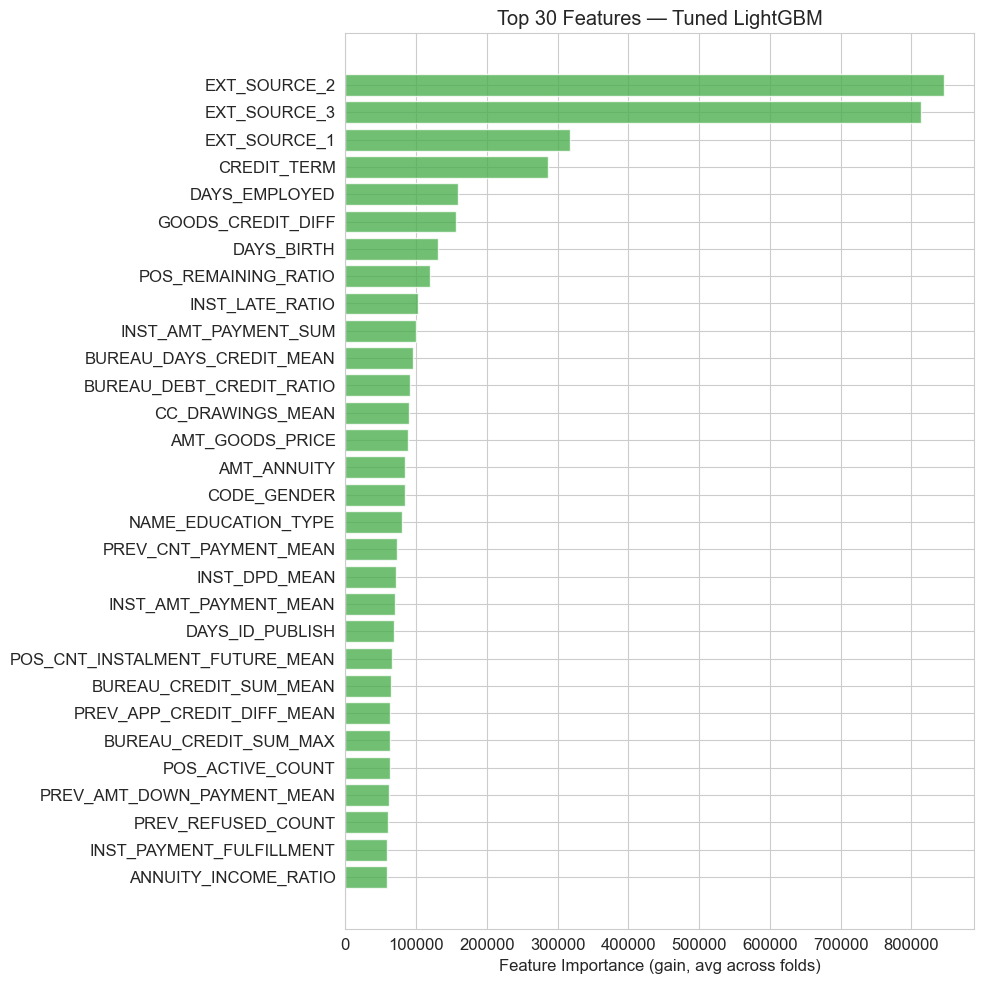

Top 20 Features:
                 feature    importance
            EXT_SOURCE_2 846062.100917
            EXT_SOURCE_3 812923.906502
            EXT_SOURCE_1 317462.285187
             CREDIT_TERM 285824.841072
           DAYS_EMPLOYED 159268.998899
       GOODS_CREDIT_DIFF 156407.990243
              DAYS_BIRTH 131222.341987
     POS_REMAINING_RATIO 119126.872846
         INST_LATE_RATIO 102636.804704
    INST_AMT_PAYMENT_SUM  99755.799774
 BUREAU_DAYS_CREDIT_MEAN  95208.588652
BUREAU_DEBT_CREDIT_RATIO  91493.194187
        CC_DRAWINGS_MEAN  89986.607031
         AMT_GOODS_PRICE  89080.908806
             AMT_ANNUITY  84797.535291
             CODE_GENDER  83644.125488
     NAME_EDUCATION_TYPE  80024.835767
   PREV_CNT_PAYMENT_MEAN  72331.903196
           INST_DPD_MEAN  70896.484481
   INST_AMT_PAYMENT_MEAN  70497.684027


In [21]:
# Feature Importance — Gain (split count yerine, daha anlamlı etki ölçümü)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.mean([
        m.booster_.feature_importance(importance_type='gain')
        for m in final_models
    ], axis=0)
})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Top 30 features
top_n = 30
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(
    range(top_n),
    top_features['importance'].values[::-1],
    color='#4CAF50', alpha=0.8
)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Feature Importance (gain, avg across folds)')
ax.set_title(f'Top {top_n} Features — Tuned LightGBM')
plt.tight_layout()
plt.savefig('../notebooks/plots/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top 20
print('Top 20 Features:')
print(importance_df.head(20).to_string(index=False))

---
## 8. Calibration Kontrolü

Bankacılık risk modeli olduğu için **probability calibration** kritik:

| Soru | Neden Önemli |
|------|-------------|
| Model 0.8 dediğinde gerçekten %80 default riski mi? | Business kararları olasılığa dayanır |
| **Brier Score** nedir? | Genel calibration kalitesi (0=mükemmel) |
| **Calibration Curve** ne gösterir? | Predicted vs Actual probability eşleşmesi |
| Sapma varsa ne yapılır? | Platt (sigmoid) veya Isotonic scaling |

> PR-AUC iyi olabilir ama probability'ler calibrated değilse
> **business tarafında patlayabilir**. Bu adım çoğu kişi tarafından atlanır.

CALIBRATION KONTROLÜ — Final Model OOF

  Brier Score (tuned model): 0.167987
  Brier Score (naive):       0.074212
  Brier Skill Score:         -1.2636
    (1 = mükemmel, 0 = naive kadar, <0 = naive'den kötü)

  Calibration Tablosu (10 bin):
     Predicted     Actual   Ratio(A/P)     Durum
  ----------------------------------------------
        0.0687     0.0081         0.12         ⚠
        0.1501     0.0186         0.12         ⚠
        0.2486     0.0330         0.13         ⚠
        0.3483     0.0514         0.15         ⚠
        0.4487     0.0772         0.17         ⚠
        0.5485     0.1129         0.21         ⚠
        0.6484     0.1638         0.25         ⚠
        0.7475     0.2422         0.32         ⚠
        0.8415     0.3805         0.45         ⚠
        0.9157     0.6132         0.67         ✓


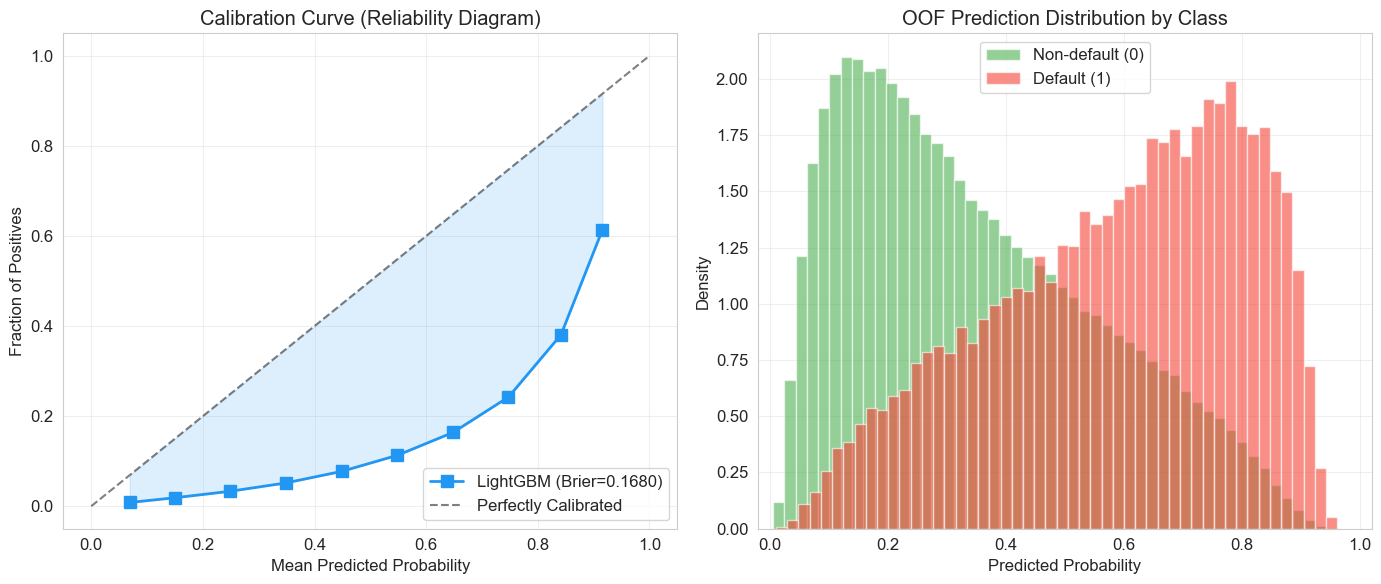


--- Calibration Değerlendirmesi ---
  Max ratio (Actual/Predicted): 0.67
  Min ratio (Actual/Predicted): 0.12
  Mean Absolute Calibration Error: 0.3265

  ⚠ Calibration moderate — bazı bölgelerde sapma var.
    Production'da Platt scaling önerilir.

  Not: OOF predictions zaten cross-validated olduğu için,
  calibration'ı doğrudan OOF üzerinde fit etmek leakage yaratır.
  Production için nested CV veya ayrı calibration set kullanılmalı.


In [22]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

print('=' * 70)
print('CALIBRATION KONTROLÜ — Final Model OOF')
print('=' * 70)

# ---- Brier Score ----
brier = brier_score_loss(y, final_oof_preds)
baseline_brier = y.mean() * (1 - y.mean())   # naive baseline (always predict prevalence)
brier_skill = 1 - brier / baseline_brier

print(f'\n  Brier Score (tuned model): {brier:.6f}')
print(f'  Brier Score (naive):       {baseline_brier:.6f}')
print(f'  Brier Skill Score:         {brier_skill:.4f}')
print(f'    (1 = mükemmel, 0 = naive kadar, <0 = naive\'den kötü)')

# ---- Calibration Curve (10 bins) ----
prob_true, prob_pred = calibration_curve(y, final_oof_preds, n_bins=10, strategy='uniform')

print(f'\n  Calibration Tablosu (10 bin):')
print(f'  {"Predicted":>12s} {"Actual":>10s} {"Ratio(A/P)":>12s}  {"Durum":>8s}')
print(f'  {"-"*46}')
for pt, pp in zip(prob_true, prob_pred):
    ratio = pt / pp if pp > 0 else float('inf')
    flag = '⚠' if (ratio > 2.0 or ratio < 0.5) else '✓'
    print(f'  {pp:12.4f} {pt:10.4f} {ratio:12.2f}  {flag:>8s}')

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Reliability diagram
axes[0].plot(prob_pred, prob_true, 's-', color='#2196F3', linewidth=2,
             markersize=8, label=f'LightGBM (Brier={brier:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfectly Calibrated')
axes[0].fill_between(prob_pred, prob_true, prob_pred, alpha=0.15, color='#2196F3')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Curve (Reliability Diagram)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Prediction distribution by class
axes[1].hist(final_oof_preds[y == 0], bins=50, alpha=0.6,
             label='Non-default (0)', color='#4CAF50', density=True)
axes[1].hist(final_oof_preds[y == 1], bins=50, alpha=0.6,
             label='Default (1)', color='#F44336', density=True)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('OOF Prediction Distribution by Class')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-0.02, 1.02)

plt.tight_layout()
plt.savefig('../notebooks/plots/calibration_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- Calibration Assessment ----
print('\n--- Calibration Değerlendirmesi ---')
ratios = prob_true / np.where(prob_pred > 0, prob_pred, 1e-10)
max_ratio = ratios.max()
min_ratio = ratios.min()
mean_abs_err = np.mean(np.abs(prob_true - prob_pred))

print(f'  Max ratio (Actual/Predicted): {max_ratio:.2f}')
print(f'  Min ratio (Actual/Predicted): {min_ratio:.2f}')
print(f'  Mean Absolute Calibration Error: {mean_abs_err:.4f}')

if max_ratio < 2.0 and min_ratio > 0.5:
    print('\n  ✓ Calibration kabul edilebilir (ratio 0.5-2.0 arası).')
    print('    Production\'da ilave Platt/Isotonic scaling optional.')
    calibration_status = 'GOOD'
elif max_ratio < 3.0:
    print('\n  ⚠ Calibration moderate — bazı bölgelerde sapma var.')
    print('    Production\'da Platt scaling önerilir.')
    calibration_status = 'MODERATE'
else:
    print('\n  ⚠ Calibration zayıf — ciddi sapma mevcut.')
    print('    Production\'da mutlaka calibration gerekli.')
    calibration_status = 'POOR'

print(f'\n  Not: OOF predictions zaten cross-validated olduğu için,')
print(f'  calibration\'ı doğrudan OOF üzerinde fit etmek leakage yaratır.')
print(f'  Production için nested CV veya ayrı calibration set kullanılmalı.')

### 8b. Calibration Fix — Platt Scaling

**Problem:** `scale_pos_weight=11.39` olasılıkları yukarı şişiriyor.
Model 0.35 dediğinde gerçekte %5 default oranı var. **Ranking doğru, probability yanlış.**

**Çözüm:** OOF tahminleri üzerinden **Platt Scaling** (2 parametreli logistic regression).
- OOF predictions zaten cross-validated → fit etmek güvenli (307K sample, 2 parametre → overfit riski ~0)
- Calibrated probabilities business-ready olacak
- Test predictions'a da aynı transform uygulanacak

CALIBRATION FIX — Platt Scaling

  Platt parameters:
    slope:     4.9077
    intercept: -4.7245

  Brier Score Comparison:
    Before (raw):       0.167987
    After (calibrated): 0.066138
    Naive baseline:     0.074212
    Skill (before):     -1.2636
    Skill (after):      0.1088

  Discrimination (should be identical — monotonic transform):
    AUC    before: 0.78664  |  after: 0.78664
    PR-AUC before: 0.27964  |  after: 0.27964

  Calibrated Calibration Tablosu:
     Predicted     Actual   Ratio(A/P)     Durum
  ----------------------------------------------
        0.0365     0.0379         1.04         ✓
        0.1429     0.1356         0.95         ✓
        0.2450     0.2274         0.93         ✓
        0.3427     0.3534         1.03         ✓
        0.4250     0.5564         1.31         ✓
        0.5009     0.0000         0.00         ⚠


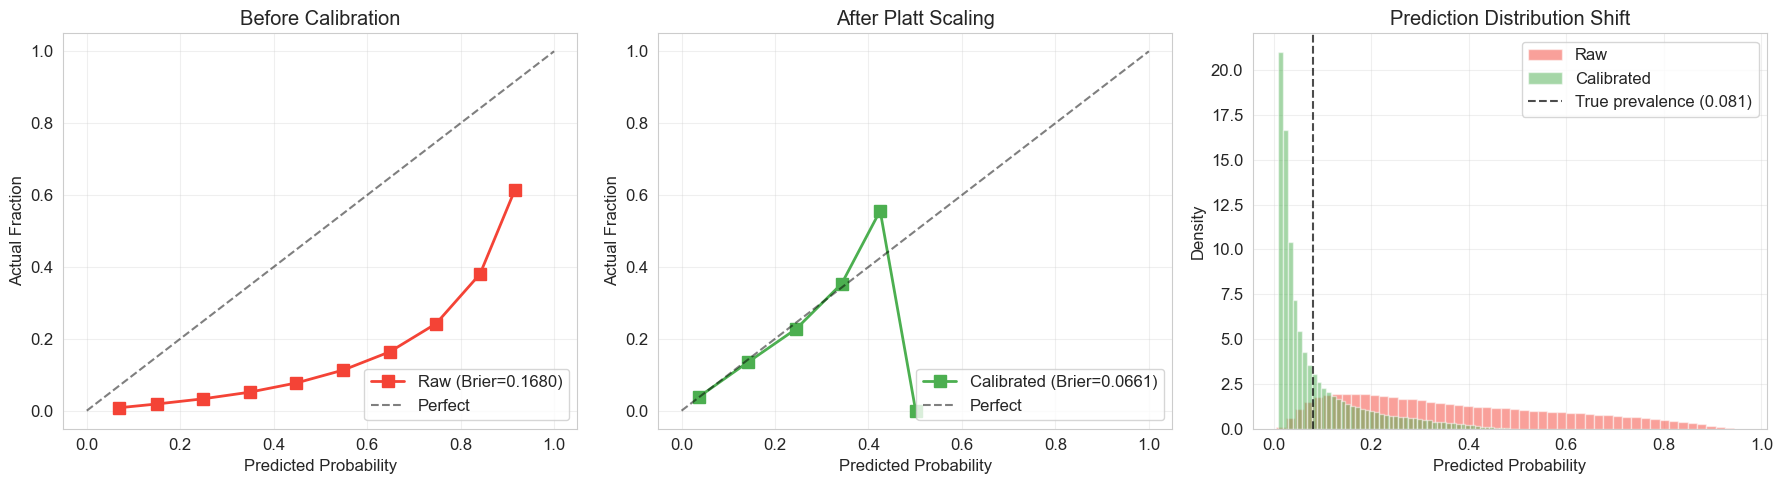


Platt Scaling başarılı.
  Brier Skill: -1.2636 → 0.1088
  Calibrated predictions threshold analizinde kullanılacak.


In [24]:
from sklearn.linear_model import LogisticRegression

print('=' * 70)
print('CALIBRATION FIX — Platt Scaling')
print('=' * 70)

# ---- Platt Scaling: Logistic Regression on OOF predictions ----
# OOF preds are cross-validated → safe to fit on all 307K samples
# 2 parameters (intercept + slope) on 307K → overfit risk = ~0

platt_model = LogisticRegression(C=1e10, solver='lbfgs', max_iter=1000)
platt_model.fit(final_oof_preds.reshape(-1, 1), y)

print(f'\n  Platt parameters:')
print(f'    slope:     {platt_model.coef_[0][0]:.4f}')
print(f'    intercept: {platt_model.intercept_[0]:.4f}')

# ---- Apply calibration ----
calibrated_oof = platt_model.predict_proba(final_oof_preds.reshape(-1, 1))[:, 1]
calibrated_test_ensemble = platt_model.predict_proba(final_test_preds.reshape(-1, 1))[:, 1]
calibrated_test_full = platt_model.predict_proba(full_test_preds.reshape(-1, 1))[:, 1]

# ---- Before vs After comparison ----
brier_before = brier_score_loss(y, final_oof_preds)
brier_after = brier_score_loss(y, calibrated_oof)
baseline_brier = y.mean() * (1 - y.mean())

print(f'\n  Brier Score Comparison:')
print(f'    Before (raw):       {brier_before:.6f}')
print(f'    After (calibrated): {brier_after:.6f}')
print(f'    Naive baseline:     {baseline_brier:.6f}')
print(f'    Skill (before):     {1 - brier_before/baseline_brier:.4f}')
print(f'    Skill (after):      {1 - brier_after/baseline_brier:.4f}')

# AUC should be preserved (monotonic transform)
from sklearn.metrics import roc_auc_score, average_precision_score
auc_before = roc_auc_score(y, final_oof_preds)
auc_after = roc_auc_score(y, calibrated_oof)
prauc_before = average_precision_score(y, final_oof_preds)
prauc_after = average_precision_score(y, calibrated_oof)

print(f'\n  Discrimination (should be identical — monotonic transform):')
print(f'    AUC    before: {auc_before:.5f}  |  after: {auc_after:.5f}')
print(f'    PR-AUC before: {prauc_before:.5f}  |  after: {prauc_after:.5f}')

# ---- Calibrated calibration curve ----
prob_true_cal, prob_pred_cal = calibration_curve(y, calibrated_oof, n_bins=10, strategy='uniform')

print(f'\n  Calibrated Calibration Tablosu:')
print(f'  {"Predicted":>12s} {"Actual":>10s} {"Ratio(A/P)":>12s}  {"Durum":>8s}')
print(f'  {"-"*46}')
for pt, pp in zip(prob_true_cal, prob_pred_cal):
    ratio = pt / pp if pp > 0 else float('inf')
    flag = '⚠' if (ratio > 2.0 or ratio < 0.5) else '✓'
    print(f'  {pp:12.4f} {pt:10.4f} {ratio:12.2f}  {flag:>8s}')

# ---- Visualization: Before vs After ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Before calibration
axes[0].plot(prob_pred, prob_true, 's-', color='#F44336', linewidth=2,
             markersize=8, label=f'Raw (Brier={brier_before:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Actual Fraction')
axes[0].set_title('Before Calibration')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# After calibration
axes[1].plot(prob_pred_cal, prob_true_cal, 's-', color='#4CAF50', linewidth=2,
             markersize=8, label=f'Calibrated (Brier={brier_after:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Actual Fraction')
axes[1].set_title('After Platt Scaling')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# Distribution shift
axes[2].hist(final_oof_preds, bins=50, alpha=0.5, label='Raw', color='#F44336', density=True)
axes[2].hist(calibrated_oof, bins=50, alpha=0.5, label='Calibrated', color='#4CAF50', density=True)
axes[2].axvline(x=y.mean(), color='black', linestyle='--', alpha=0.7,
                label=f'True prevalence ({y.mean():.3f})')
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Density')
axes[2].set_title('Prediction Distribution Shift')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/calibration_fix.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- Save calibrated predictions ----
# Update OOF and test with calibrated values
calibrated_oof_preds = calibrated_oof  # for threshold optimization cell
print(f'\n{"="*70}')
print(f'Platt Scaling başarılı.')
print(f'  Brier Skill: {1-brier_before/baseline_brier:.4f} → {1-brier_after/baseline_brier:.4f}')
print(f'  Calibrated predictions threshold analizinde kullanılacak.')
print(f'{"="*70}')

---
## 9. Threshold Optimizasyonu — Calibrated OOF

Önceki threshold analizi (Adım 6) **baseline** OOF üzerindeydi.
Şimdi **calibrated (Platt Scaling)** OOF tahminleri ile:

- **Business Cost Matrix** tanımla: FN (kaçırılan default) >> FP (yanlış ret)
- **Expected Loss** minimize eden threshold'u bul
- F1-optimal ve Cost-optimal karşılaştır

> Bu adım leaderboard'dan daha önemli — production'da **gerçek para**.
> `COST_FN` ve `COST_FP` değerleri gerçek business maliyetlerine göre ayarlanmalı.

THRESHOLD OPTİMİZASYONU — Calibrated OOF (Platt Scaled)

  Business Cost Matrix:
    FN (kaçırılan default):  10x
    FP (yanlış ret):         1x
    FN/FP oranı:            10/1 = 10:1

--- Optimal Threshold Sonuçları ---

  1) F1-Optimal Threshold: 0.178
     Precision: 0.2682
     Recall:    0.4554
     F1:        0.3376
     TP=11,306  FP=30,856  FN=13,519  TN=251,830

  2) Cost-Optimal Threshold: 0.090
     Precision: 0.1913
     Recall:    0.6837
     F1:        0.2990
     TP=16,972  FP=71,737  FN=7,853  TN=210,949
     Total Cost:  150,267
     Cost/Sample: 0.4887

--- Karşılaştırma Tablosu ---
 threshold  precision  recall     f1         tp         fp         fn          tn  cost_per_sample
    0.0900     0.1913  0.6837 0.2990 16972.0000 71737.0000  7853.0000 210949.0000           0.4887
    0.1000     0.2010  0.6541 0.3075 16239.0000 64552.0000  8586.0000 218134.0000           0.4891
    0.1500     0.2439  0.5210 0.3323 12935.0000 40099.0000 11890.0000 242587.0000           0

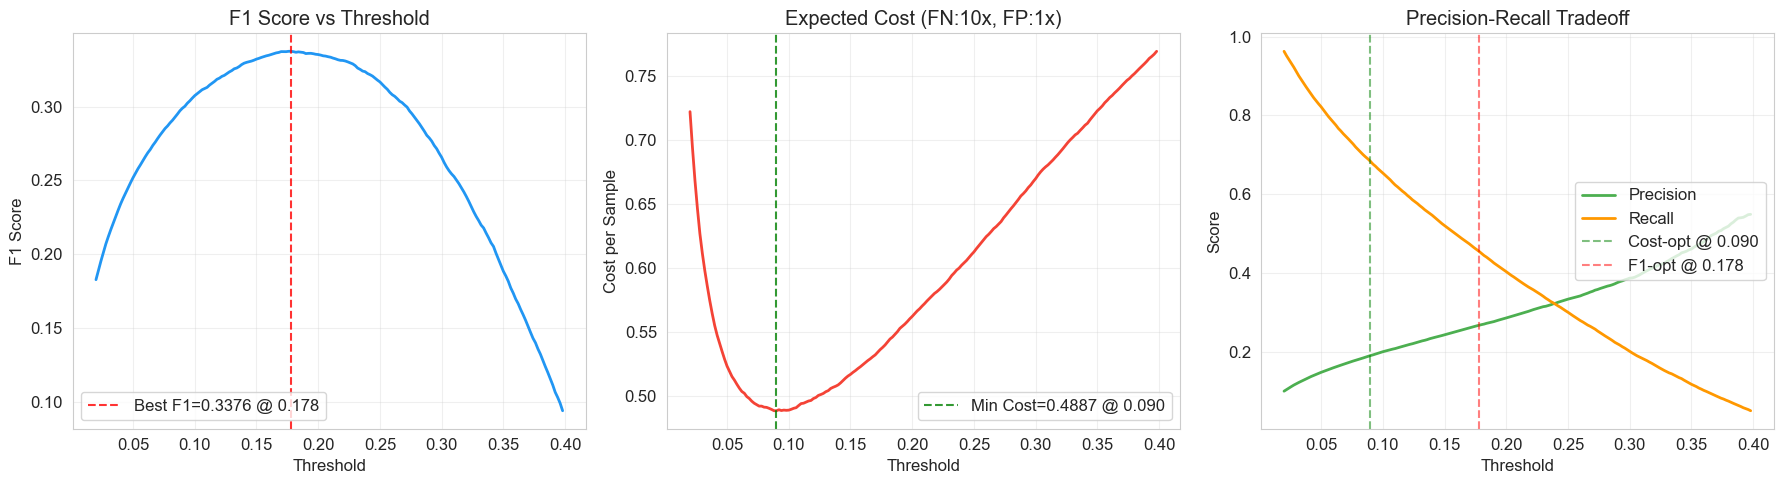


ÖNERİ:
  Bankacılık risk modeli için Cost-Optimal threshold: 0.090
  Bu threshold ile:
    - Default yakalama (Recall): 68.4%
    - Hassasiyet (Precision):    19.1%
    - F1 Score:                  0.2990
    - Toplam maliyet:            150,267 birim

  Not: COST_FN=10, COST_FP=1 varsayımıyla.
  Gerçek business maliyetleri ile yeniden optimize edilmeli.


In [25]:
print('=' * 70)
print('THRESHOLD OPTİMİZASYONU — Calibrated OOF (Platt Scaled)')
print('=' * 70)

# ---- Business Cost Matrix ----
# FN (kaçırılan default) → kredi verilir, default olur → yüksek kayıp
# FP (yanlış alarm) → kredi reddedilir, iyi müşteri kaybı → düşük kayıp
COST_FN = 10   # Kaçırılan default maliyeti (kredi kaybı)
COST_FP = 1    # Yanlış ret maliyeti (müşteri kaybı)

print(f'\n  Business Cost Matrix:')
print(f'    FN (kaçırılan default):  {COST_FN}x')
print(f'    FP (yanlış ret):         {COST_FP}x')
print(f'    FN/FP oranı:            {COST_FN}/{COST_FP} = {COST_FN/COST_FP:.0f}:1')

# ---- Threshold Sweep (calibrated predictions) ----
thresholds = np.arange(0.02, 0.40, 0.002)
opt_results = []

for thr in thresholds:
    y_pred_bin = (calibrated_oof_preds >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_bin).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    total_cost = COST_FN * fn + COST_FP * fp
    cost_per_sample = total_cost / len(y)

    opt_results.append({
        'threshold': thr, 'precision': precision, 'recall': recall, 'f1': f1,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'total_cost': total_cost, 'cost_per_sample': cost_per_sample
    })

opt_df = pd.DataFrame(opt_results)

# ---- Optimal Thresholds ----
best_f1_idx = opt_df['f1'].idxmax()
best_cost_idx = opt_df['cost_per_sample'].idxmin()
best_f1_thr = opt_df.loc[best_f1_idx, 'threshold']
best_cost_thr = opt_df.loc[best_cost_idx, 'threshold']

print(f'\n--- Optimal Threshold Sonuçları ---')
print(f'\n  1) F1-Optimal Threshold: {best_f1_thr:.3f}')
row_f1 = opt_df.loc[best_f1_idx]
print(f'     Precision: {row_f1["precision"]:.4f}')
print(f'     Recall:    {row_f1["recall"]:.4f}')
print(f'     F1:        {row_f1["f1"]:.4f}')
print(f'     TP={int(row_f1["tp"]):,}  FP={int(row_f1["fp"]):,}  FN={int(row_f1["fn"]):,}  TN={int(row_f1["tn"]):,}')

print(f'\n  2) Cost-Optimal Threshold: {best_cost_thr:.3f}')
row_cost = opt_df.loc[best_cost_idx]
print(f'     Precision: {row_cost["precision"]:.4f}')
print(f'     Recall:    {row_cost["recall"]:.4f}')
print(f'     F1:        {row_cost["f1"]:.4f}')
print(f'     TP={int(row_cost["tp"]):,}  FP={int(row_cost["fp"]):,}  FN={int(row_cost["fn"]):,}  TN={int(row_cost["tn"]):,}')
print(f'     Total Cost:  {int(row_cost["total_cost"]):,}')
print(f'     Cost/Sample: {row_cost["cost_per_sample"]:.4f}')

# ---- Key Thresholds Comparison ----
print(f'\n--- Karşılaştırma Tablosu ---')
key_thrs = sorted(set([0.10, 0.15, 0.20, round(best_cost_thr, 2),
                        round(best_f1_thr, 2), 0.30, 0.50]))
key_rows = []
for t in key_thrs:
    closest_idx = (opt_df['threshold'] - t).abs().idxmin()
    key_rows.append(opt_df.loc[closest_idx])
key_compare_df = pd.DataFrame(key_rows).drop_duplicates(subset='threshold')
print(key_compare_df[['threshold', 'precision', 'recall', 'f1',
                       'tp', 'fp', 'fn', 'tn', 'cost_per_sample']
                     ].to_string(index=False, float_format='%.4f'))

# ---- Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 vs Threshold
axes[0].plot(opt_df['threshold'], opt_df['f1'], color='#2196F3', linewidth=2)
axes[0].axvline(x=best_f1_thr, color='red', linestyle='--', alpha=0.8,
                label=f'Best F1={row_f1["f1"]:.4f} @ {best_f1_thr:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cost vs Threshold
axes[1].plot(opt_df['threshold'], opt_df['cost_per_sample'], color='#F44336', linewidth=2)
axes[1].axvline(x=best_cost_thr, color='green', linestyle='--', alpha=0.8,
                label=f'Min Cost={row_cost["cost_per_sample"]:.4f} @ {best_cost_thr:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Cost per Sample')
axes[1].set_title(f'Expected Cost (FN:{COST_FN}x, FP:{COST_FP}x)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Precision-Recall tradeoff
axes[2].plot(opt_df['threshold'], opt_df['precision'],
             label='Precision', color='#4CAF50', linewidth=2)
axes[2].plot(opt_df['threshold'], opt_df['recall'],
             label='Recall', color='#FF9800', linewidth=2)
axes[2].axvline(x=best_cost_thr, color='green', linestyle='--', alpha=0.5,
                label=f'Cost-opt @ {best_cost_thr:.3f}')
axes[2].axvline(x=best_f1_thr, color='red', linestyle='--', alpha=0.5,
                label=f'F1-opt @ {best_f1_thr:.3f}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision-Recall Tradeoff')
axes[2].legend(loc='center right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- Final Recommendation ----
print(f'\n{"="*70}')
print(f'ÖNERİ:')
print(f'  Bankacılık risk modeli için Cost-Optimal threshold: {best_cost_thr:.3f}')
print(f'  Bu threshold ile:')
print(f'    - Default yakalama (Recall): {row_cost["recall"]:.1%}')
print(f'    - Hassasiyet (Precision):    {row_cost["precision"]:.1%}')
print(f'    - F1 Score:                  {row_cost["f1"]:.4f}')
print(f'    - Toplam maliyet:            {int(row_cost["total_cost"]):,} birim')
print(f'\n  Not: COST_FN={COST_FN}, COST_FP={COST_FP} varsayımıyla.')
print(f'  Gerçek business maliyetleri ile yeniden optimize edilmeli.')
print(f'{"="*70}')

---
## 8. SHAP Analizi — Model Aciklanabilirligi

SHAP (SHapley Additive exPlanations) ile modelin karar mekanizmasini anliyoruz:

- **Global:** Tum veri setinde hangi feature'lar en etkili?
- **Bar Plot:** Ortalama mutlak SHAP degerleri (feature ranking)
- **Bireysel:** Tek bir musteri icin hangi faktorler riski artiriyor/azaltiyor?

> SHAP hesaplaması buyuk veride yavas oldugundan **5,000 orneklem** kullaniyoruz.

In [26]:
# Use best fold model for SHAP
best_fold_idx = np.argmax(final_results['auc'])
shap_model = final_models[best_fold_idx]

# Subsample for speed
np.random.seed(RANDOM_STATE)
sample_size = 5000
sample_idx = np.random.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx]

print(f'Computing SHAP values ({sample_size:,} samples)...')
start = time.time()

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_sample)

elapsed = time.time() - start
print(f'Done in {elapsed:.1f}s')

# For binary classification, shap_values may be list [class_0, class_1] or single array
if isinstance(shap_values, list):
    shap_vals = shap_values[1]  # positive class (default)
    expected_value = explainer.expected_value[1]
    print(f'SHAP output: list of 2 arrays (binary), using class 1')
else:
    shap_vals = shap_values
    expected_value = explainer.expected_value
    print(f'SHAP output: single array')

print(f'SHAP values shape: {shap_vals.shape}')
print(f'Expected value (base): {expected_value:.4f}')

Computing SHAP values (5,000 samples)...
Done in 6.2s
SHAP output: single array
SHAP values shape: (5000, 167)
Expected value (base): -0.6491


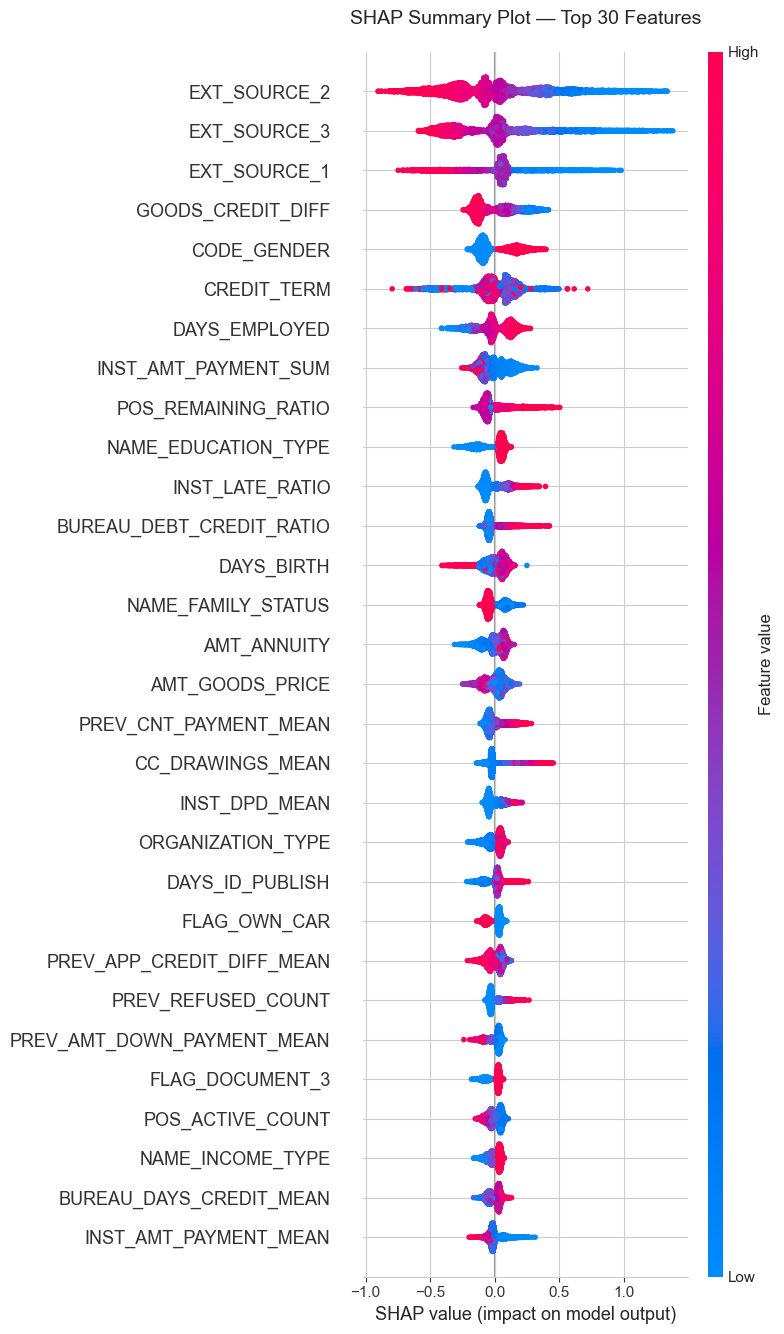

In [27]:
# Global SHAP Summary Plot (beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals, X_sample, max_display=30, show=False)
plt.title('SHAP Summary Plot — Top 30 Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

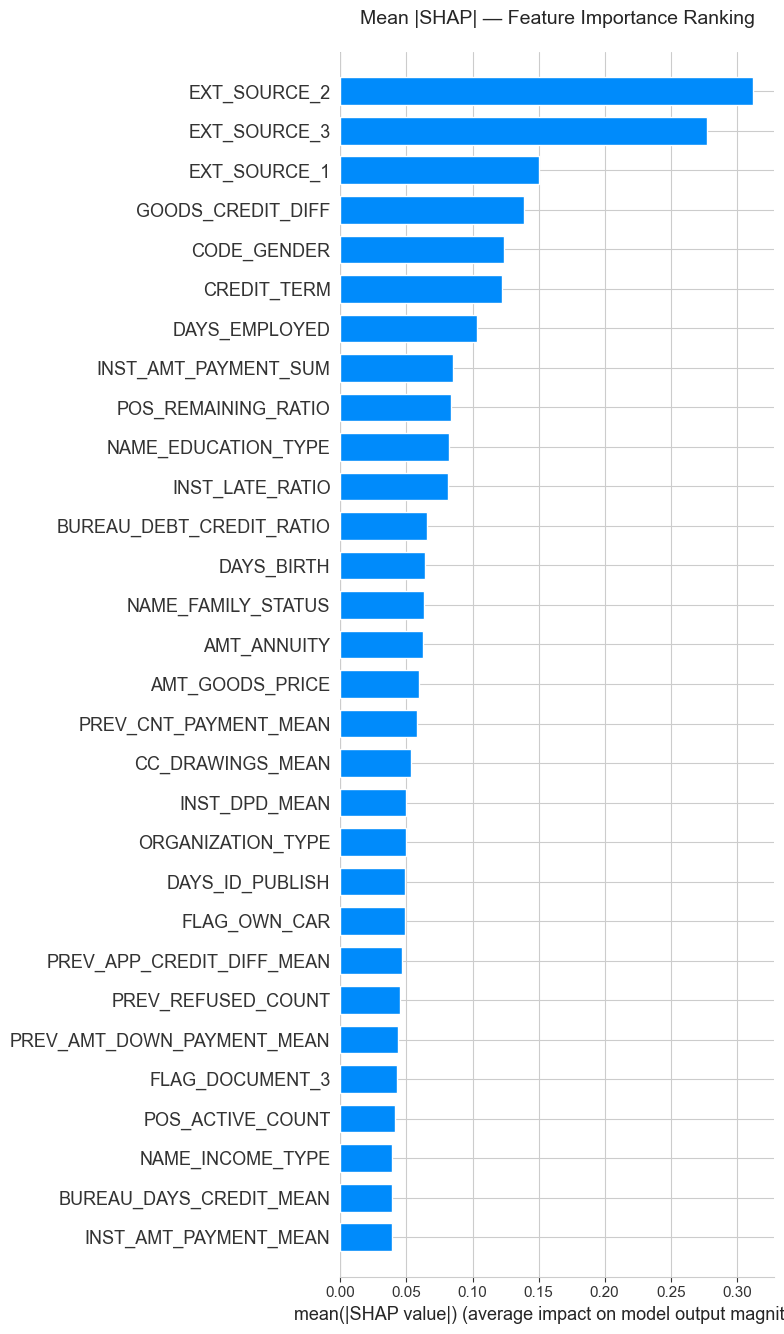


Top 15 Features by SHAP:
                 feature  mean_abs_shap
            EXT_SOURCE_2       0.312500
            EXT_SOURCE_3       0.277197
            EXT_SOURCE_1       0.150285
       GOODS_CREDIT_DIFF       0.138621
             CODE_GENDER       0.124013
             CREDIT_TERM       0.122171
           DAYS_EMPLOYED       0.103720
    INST_AMT_PAYMENT_SUM       0.085150
     POS_REMAINING_RATIO       0.083955
     NAME_EDUCATION_TYPE       0.081918
         INST_LATE_RATIO       0.081220
BUREAU_DEBT_CREDIT_RATIO       0.065235
              DAYS_BIRTH       0.063789
      NAME_FAMILY_STATUS       0.063334
             AMT_ANNUITY       0.062379


In [28]:
# SHAP Bar Plot (mean |SHAP|)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals, X_sample, plot_type='bar', max_display=30, show=False)
plt.title('Mean |SHAP| — Feature Importance Ranking', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

# SHAP vs LightGBM feature importance comparison
shap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': np.abs(shap_vals).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print('\nTop 15 Features by SHAP:')
print(shap_importance.head(15).to_string(index=False))

In [29]:
# Individual SHAP Explanations
# Find high-risk and low-risk examples from our sample
sample_preds = final_oof_preds[sample_idx]
high_risk_local = np.argmax(sample_preds)
low_risk_local = np.argmin(sample_preds)

print('HIGH-RISK Customer:')
print(f'  Sample index: {high_risk_local}')
print(f'  Predicted probability: {sample_preds[high_risk_local]:.4f}')
print(f'  Actual TARGET: {y.iloc[sample_idx[high_risk_local]]}')

print(f'\nLOW-RISK Customer:')
print(f'  Sample index: {low_risk_local}')
print(f'  Predicted probability: {sample_preds[low_risk_local]:.4f}')
print(f'  Actual TARGET: {y.iloc[sample_idx[low_risk_local]]}')

HIGH-RISK Customer:
  Sample index: 4071
  Predicted probability: 0.9565
  Actual TARGET: 1

LOW-RISK Customer:
  Sample index: 1354
  Predicted probability: 0.0193
  Actual TARGET: 0


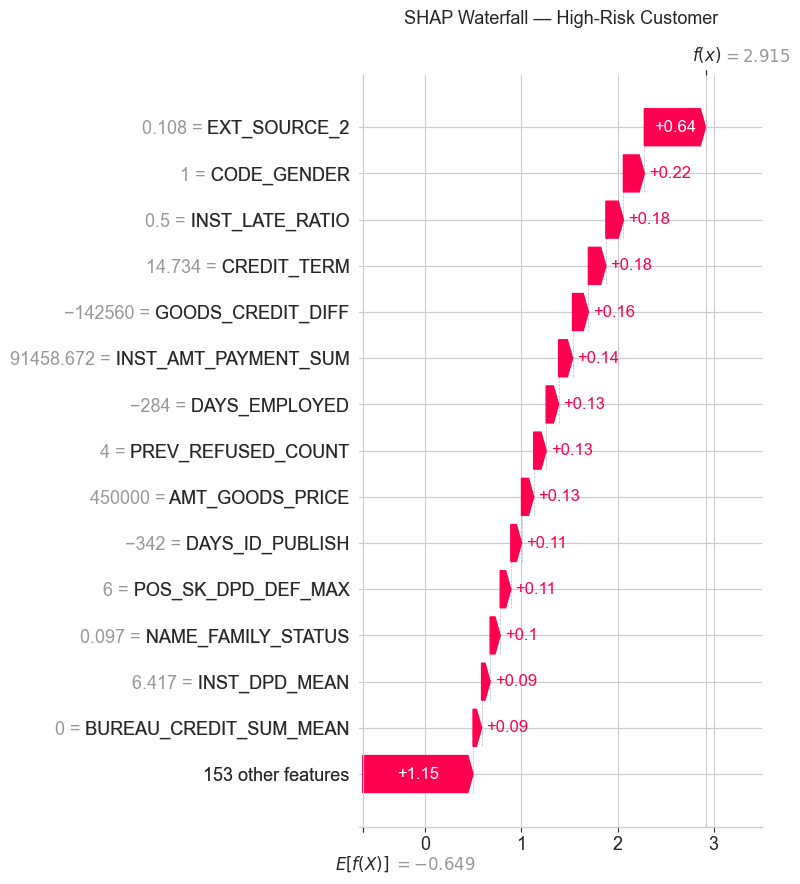

In [30]:
# High-risk waterfall
shap_exp_high = shap.Explanation(
    values=shap_vals[high_risk_local],
    base_values=expected_value,
    data=X_sample.iloc[high_risk_local].values,
    feature_names=X_sample.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_exp_high, max_display=15, show=False)
plt.title('SHAP Waterfall — High-Risk Customer', fontsize=13, pad=15)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

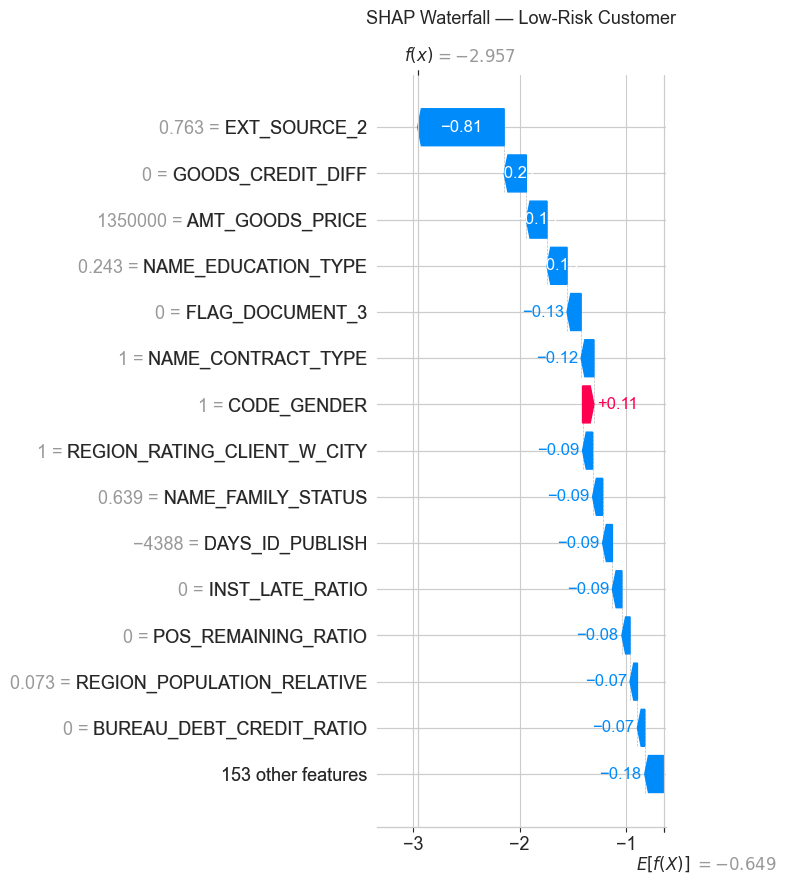

In [31]:
# Low-risk waterfall
shap_exp_low = shap.Explanation(
    values=shap_vals[low_risk_local],
    base_values=expected_value,
    data=X_sample.iloc[low_risk_local].values,
    feature_names=X_sample.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_exp_low, max_display=15, show=False)
plt.title('SHAP Waterfall — Low-Risk Customer', fontsize=13, pad=15)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_low_risk.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Model Kaydetme ve Test Tahminleri

In [32]:
# Save models
best_fold_idx = np.argmax(final_results['auc'])

with open('../models/lgbm_best_fold.pkl', 'wb') as f:
    pickle.dump(final_models[best_fold_idx], f)

with open('../models/lgbm_all_folds.pkl', 'wb') as f:
    pickle.dump(final_models, f)

with open('../models/lgbm_full_model.pkl', 'wb') as f:
    pickle.dump(full_model, f)

with open('../models/platt_calibrator.pkl', 'wb') as f:
    pickle.dump(platt_model, f)

# Save OOF predictions
oof_df = pd.DataFrame({
    'SK_ID_CURR': df['SK_ID_CURR'],
    'TARGET': y,
    'PREDICTED_PROBA': final_oof_preds
})
oof_df.to_parquet('../data/oof_predictions.parquet', index=False)

# Save test predictions (5-fold ensemble average)
test_pred_df = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'PREDICTED_PROBA': final_test_preds
})
test_pred_df.to_parquet('../data/test_predictions.parquet', index=False)

# Save full-model test predictions
full_test_pred_df = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'PREDICTED_PROBA': full_test_preds
})
full_test_pred_df.to_parquet('../data/test_predictions_full.parquet', index=False)

# Save calibrated predictions
cal_oof_df = pd.DataFrame({
    'SK_ID_CURR': df['SK_ID_CURR'],
    'TARGET': y,
    'RAW_PROBA': final_oof_preds,
    'CALIBRATED_PROBA': calibrated_oof_preds
})
cal_oof_df.to_parquet('../data/oof_predictions_calibrated.parquet', index=False)

cal_test_df = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'ENSEMBLE_RAW': final_test_preds,
    'ENSEMBLE_CALIBRATED': calibrated_test_ensemble,
    'FULL_RAW': full_test_preds,
    'FULL_CALIBRATED': calibrated_test_full
})
cal_test_df.to_parquet('../data/test_predictions_calibrated.parquet', index=False)

# Save best parameters
params_export = final_params.copy()
params_export['best_cv_auc_mean'] = float(np.mean(final_results['auc']))
params_export['best_cv_auc_std'] = float(np.std(final_results['auc']))
params_export['best_cv_prauc_mean'] = float(np.mean(final_results['pr_auc']))
params_export['oof_auc'] = float(final_oof_auc)
params_export['oof_prauc'] = float(final_oof_prauc)
params_export['n_folds'] = N_FOLDS
params_export['n_optuna_trials'] = len(study.trials) + len(study_prauc.trials)
params_export['selected_study'] = best_study_name
params_export['brier_score'] = float(brier)
params_export['brier_skill_score'] = float(brier_skill)
params_export['calibration_status'] = calibration_status
params_export['threshold_f1_optimal'] = float(best_f1_thr)
params_export['threshold_cost_optimal'] = float(best_cost_thr)
params_export['cost_fn'] = COST_FN
params_export['cost_fp'] = COST_FP
params_export['full_model_n_estimators'] = full_n_estimators
params_export['full_model_mean_best_iter'] = mean_best_iter
params_export['platt_slope'] = float(platt_model.coef_[0][0])
params_export['platt_intercept'] = float(platt_model.intercept_[0])
params_export['brier_score_calibrated'] = float(brier_score_loss(y, calibrated_oof_preds))

with open('../models/best_params.json', 'w') as f:
    json.dump(params_export, f, indent=2, default=str)

# Save SHAP values
np.save('../models/shap_values.npy', shap_vals)
X_sample.to_parquet('../models/shap_sample.parquet', index=False)

print('All artifacts saved:')
print(f'  models/lgbm_best_fold.pkl       — Best single fold model')
print(f'  models/lgbm_all_folds.pkl       — All {N_FOLDS} fold models')
print(f'  models/lgbm_full_model.pkl      — Full-data single model')
print(f'  models/platt_calibrator.pkl     — Platt scaling model')
print(f'  models/best_params.json         — Hyperparameters + CV scores')
print(f'  models/shap_values.npy          — SHAP values ({sample_size:,} samples)')
print(f'  models/shap_sample.parquet      — SHAP sample features')
print(f'  data/oof_predictions.parquet    — OOF predictions ({len(oof_df):,} rows)')
print(f'  data/test_predictions.parquet   — Test ensemble ({len(test_pred_df):,} rows)')
print(f'  data/test_predictions_full.parquet — Full model ({len(full_test_pred_df):,} rows)')
print(f'  data/oof_predictions_calibrated.parquet — Calibrated OOF ({len(cal_oof_df):,} rows)')
print(f'  data/test_predictions_calibrated.parquet — Calibrated test ({len(cal_test_df):,} rows)')

All artifacts saved:
  models/lgbm_best_fold.pkl       — Best single fold model
  models/lgbm_all_folds.pkl       — All 5 fold models
  models/lgbm_full_model.pkl      — Full-data single model
  models/platt_calibrator.pkl     — Platt scaling model
  models/best_params.json         — Hyperparameters + CV scores
  models/shap_values.npy          — SHAP values (5,000 samples)
  models/shap_sample.parquet      — SHAP sample features
  data/oof_predictions.parquet    — OOF predictions (307,511 rows)
  data/test_predictions.parquet   — Test ensemble (48,744 rows)
  data/test_predictions_full.parquet — Full model (48,744 rows)
  data/oof_predictions_calibrated.parquet — Calibrated OOF (307,511 rows)
  data/test_predictions_calibrated.parquet — Calibrated test (48,744 rows)


---
## 10. Sonuc Ozeti

In [33]:
print('=' * 70)
print('                    MODEL TRAINING — FINAL SUMMARY')
print('=' * 70)

print(f'\n1. BASELINE COMPARISON:')
print(f'   LightGBM AUC: {np.mean(lgb_results["auc"]):.5f} +/- {np.std(lgb_results["auc"]):.5f}')
print(f'   XGBoost  AUC: {np.mean(xgb_results["auc"]):.5f} +/- {np.std(xgb_results["auc"]):.5f}')
print(f'   Winner: {best_baseline}')

print(f'\n2. OPTUNA TUNING ({len(study.trials)}+{len(study_prauc.trials)} trials):')
print(f'   AUC Study Best:   {study.best_value:.5f}')
print(f'   PR-AUC Study Best: {study_prauc.best_value:.5f}')
print(f'   Selected: {best_study_name}')

print(f'\n3. FINAL MODEL (Tuned LightGBM):')
print(f'   CV AUC:    {np.mean(final_results["auc"]):.5f} +/- {np.std(final_results["auc"]):.5f}')
print(f'   CV PR-AUC: {np.mean(final_results["pr_auc"]):.5f} +/- {np.std(final_results["pr_auc"]):.5f}')
print(f'   OOF AUC:   {final_oof_auc:.5f}')
print(f'   Improvement over baseline: {(tuned_auc - baseline_auc)*10000:+.1f} bps')

print(f'\n4. CALIBRATION:')
print(f'   Brier Score:      {brier:.6f}')
print(f'   Brier Skill:      {brier_skill:.4f}')
print(f'   Calibration:      {calibration_status}')

print(f'\n5. THRESHOLD OPTIMIZATION:')
print(f'   F1-Optimal:       {best_f1_thr:.3f} (F1={opt_df.loc[best_f1_idx, "f1"]:.4f})')
print(f'   Cost-Optimal:     {best_cost_thr:.3f} (Recall={opt_df.loc[best_cost_idx, "recall"]:.1%})')
print(f'   Cost Matrix:      FN={COST_FN}x, FP={COST_FP}x')

print(f'\n6. TOP 10 FEATURES (SHAP):')
for i, row in shap_importance.head(10).iterrows():
    print(f'   {i+1:2d}. {row["feature"]:40s} |SHAP|={row["mean_abs_shap"]:.4f}')

print(f'\n7. OUTPUT FILES:')
print(f'   models/lgbm_best_fold.pkl')
print(f'   models/lgbm_all_folds.pkl')
print(f'   models/best_params.json')
print(f'   data/oof_predictions.parquet')
print(f'   data/test_predictions.parquet')

print(f'\n{"="*70}')
print(f'  SONRAKI ADIM: Risk Scoring API gelistirme')
print(f'  - Dinamik risk skoru (0-100)')
print(f'  - Her tahmin icin top-3 katki yapan faktor (SHAP)')
print(f'  - Yeni islem simulasyon endpoint')
print(f'{"="*70}')

                    MODEL TRAINING — FINAL SUMMARY

1. BASELINE COMPARISON:
   LightGBM AUC: 0.78422 +/- 0.00338
   XGBoost  AUC: 0.78144 +/- 0.00345
   Winner: LightGBM

2. OPTUNA TUNING (50+50 trials):
   AUC Study Best:   0.78724
   PR-AUC Study Best: 0.27960
   Selected: PR-AUC-optimized

3. FINAL MODEL (Tuned LightGBM):
   CV AUC:    0.78682 +/- 0.00286
   CV PR-AUC: 0.28015 +/- 0.00577
   OOF AUC:   0.78664
   Improvement over baseline: +26.0 bps

4. CALIBRATION:
   Brier Score:      0.167987
   Brier Skill:      -1.2636
   Calibration:      MODERATE

5. THRESHOLD OPTIMIZATION:
   F1-Optimal:       0.178 (F1=0.3376)
   Cost-Optimal:     0.090 (Recall=68.4%)
   Cost Matrix:      FN=10x, FP=1x

6. TOP 10 FEATURES (SHAP):
    1. EXT_SOURCE_2                             |SHAP|=0.3125
    2. EXT_SOURCE_3                             |SHAP|=0.2772
    3. EXT_SOURCE_1                             |SHAP|=0.1503
    4. GOODS_CREDIT_DIFF                        |SHAP|=0.1386
    5. CODE_GENDE